This notebook generaters synthetic building data sets that can be used to develop and test end-use load decomposition methods.

# Preparation

The following verifies that the host system is prepared for this notebook.

We recommend using GridLAB-D Version 4.2 or later.

In [1]:
!gridlabd --version='-ge 4.2'

If you don't have GridLAB-D installed on your system, you can install [Docker Desktop](https://www.docker.com/get-started). On Macs and Linux machines, you can create a script in `/usr/local/bin/gridlabd` with the following code. Don't forget to give yourself permission to execute this script using the command `chmod +x /usr/local/bin/gridlabd`.

# Basics
The following establishes the basic common components of the GridLAB-D models we will be uses.  As the models become more complex, some of these will be extended to support added features and performance enhancements.

## Time
The time window of the simulation must be specified. We have chosen to use 2021 for an annual simulation. To specify the time window, use the following GLM code:

## Weather
The weather data must also be downloaded for the test case. To find the desired weather file, request the weather index for the state that interests you, e.g., Colorado:

In [2]:
!gridlabd weather index CO

CO-Akron_Washington_Co_Ap.tmy3
CO-Alamosa_San_Luis_Valley_Rgnl.tmy3
CO-Aspen_Pitkin_Co_Sar.tmy3
CO-Aurora_Buckley_Field_Angb.tmy3
CO-Broomfield_Jeffco_Boulder_Surfrad.tmy3
CO-Colorado_Springs_Muni_Ap.tmy3
CO-Cortez_Montezuma_Co.tmy3
CO-Craigmoffat.tmy3
CO-Denver_Centennial_Golden_Nrel.tmy3
CO-Denver_Intl_Ap.tmy3
CO-Durango_La_Plata_Co.tmy3
CO-Eagle_County_Ap.tmy3
CO-Fort_Collins_Awos.tmy3
CO-Grand_Junction_Walker_Field.tmy3
CO-Greeley_Weld_Awos.tmy3
CO-Gunnison_Co_Awos.tmy3
CO-Hayden_Yampa_Awos.tmy3
CO-La_Junta_Municipal_Ap.tmy3
CO-Lamar_Municipal.tmy3
CO-Leadville_Lake_Co.tmy3
CO-Limon.tmy3
CO-Montrose_Co_Arpt.tmy3
CO-Pueblo_Memorial_Ap.tmy3
CO-Rifle_Garfield_Rgnl.tmy3
CO-Trinidad_Las_Animas_County_Ap.tmy3


Then download the weather data for the city you have chosen. If the weather data is already downloaded the command will do nothing.

In [3]:
!gridlabd weather get "CO-Denver_Intl_Ap.tmy3"

To load the weather data, use the following GLM code. This also enable interpolation to smooth out the hourly temperature steps.

This command generates a GLM fragment that is loaded when needed:

In [4]:
!cat CO-Denver_Intl_Ap.glm

#weather get CO-Denver_Intl_Ap.tmy3
module climate;
object climate
{
	tmyfile "CO-Denver_Intl_Ap.tmy3";
	interpolate "QUADRATIC";
}


## Residential
The residential module is used to model homes, and uses the following settings to enable the data-drive end-use loads for the dishwasher, clotheswasher, dryer, waterheater, refrigerator, range, lights, and plugs. To enable these enduses when loading the module, use the following GLM code:

To obtain a list of all the available enduses, use the following command:

In [5]:
!gridlabd --modhelp residential:house | grep implicit_enduses

	set {NONE=0, DRYER=33554432, CLOTHESWASHER=16777216, WATERHEATER=1048576, EVCHARGER=524288, RANGE=262144, REFRIGERATOR=131072, FREEZER=65536, MICROWAVE=512, DISHWASHER=256, OCCUPANCY=4, PLUGS=2, LIGHTS=1} implicit_enduses; // list of implicit enduses that are active in houses


## Recording
The data collection process uses the `tape` module's `recorder` object to collect data from the house's electrical panel. The data is stored in CSV format. To enable inclusion of headers in the CSV file, ISO8601 date/time formatting, and complex number format that is compatible with the python `complex` object you should use the following GLM code.

# Single Home

We can now construct our first model.  The single home model is by default a 2500 square-foot home.  The data collection uses a recorder that sample the panel total power whenever it changes (e.g., `interval -1`).

In [6]:
!cat house.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${STARTTIME:-"2021-01-01 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
object house
{
	floor_area ${FLOORAREA:-2500 sf};
	object recorder
	{
		property "panel.power";
		file ${modelname/.glm/.csv};
		interval -1;
	};
}

Now we can run the simulation to update the CSV file if the GLM file has changed. (In this notebook, if you want to force a simulation to run again, simply delete the output CSV file.)

In [7]:
!test house.glm -nt house.csv && gridlabd house.glm

The static voltage warning is ok for now.

Note that the parameter to which the model is most sensitive can be changed. For example, the following command changes the square footage of the house (but we're not going to run it):

Now we can load the CSV output into a Pandas dataframe. Doing this requires some simple helper functions:

In [8]:
import pandas, datetime, numpy
def to_timestamp(s):
    return datetime.datetime.fromisoformat(s)
def to_real(s):
    try:
        return complex(s).real
    except:
        return float('nan')

<AxesSubplot:title={'center':'Instantaneous power'}, xlabel='timestamp', ylabel='kW'>

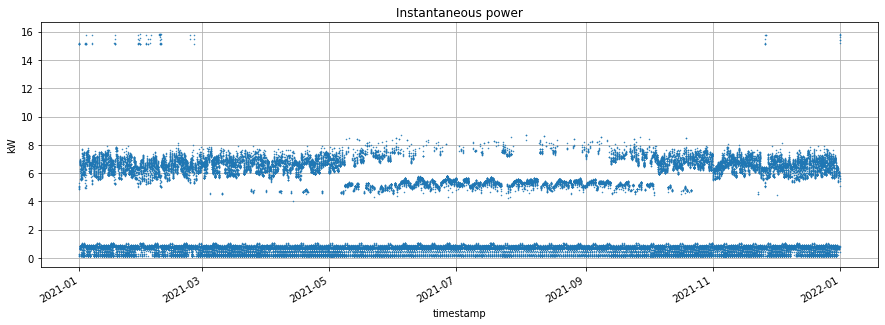

In [9]:
panel = pandas.read_csv('house.csv',
                        header = 0,
                        names = ['timestamp','power'],
                        converters = {
                            'timestamp':to_timestamp,
                            'power':to_real},
                        index_col='timestamp')
panel['power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True,title='Instantaneous power')

The result looks good.  We can clearly see the heating system running in both `HEAT` and `AUX` mode during the winter, the cooling system running in the summer, and the appliances running periodically.

Close inspection of the CSV data reveals a common problem for data analysis, i.e., the data is collected at irregular intervals:

In [10]:
!head house.csv

timestamp,panel.power
2021-01-01T00:00:00-07:00,+0.250742+0.046678j
2021-01-01T00:00:11-07:00,+4.888007+0.046678j
2021-01-01T00:11:10-07:00,+15.222674+0.046678j
2021-01-01T01:00:00-07:00,+15.146362+0.035697j
2021-01-01T01:10:24-07:00,+0.174431+0.035697j
2021-01-01T01:13:45-07:00,+4.905535+0.035697j
2021-01-01T01:40:13-07:00,+15.146362+0.035697j
2021-01-01T02:00:00-07:00,+15.118352+0.032082j
2021-01-01T02:28:06-07:00,+0.146420+0.032082j


# Metering
The solution to irregular sampling is to measure the total cumulative energy use at regular intervals, e.g., 15 minutes, and take the difference with the previous observation.  This is what meter objects do, as illustrated in the following model:

In [11]:
!cat meter.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${STARTTIME:-"2021-01-01 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120 V;
	measured_energy_delta_timestep ${SAMPLETIME:-900};
	object house
	{
		floor_area ${FLOORAREA:-2500 sf};
	};
	object recorder
	{
		property "measured_real_energy_delta";
		file ${modelname/.glm/.csv};
		interval ${SAMPLETIME:-900};		
	};
}


In [12]:
!test meter.glm -nt meter.csv && gridlabd meter.glm

Now one can see that the data is collected in regular interval, which can make analysis much easier.

In [13]:
!head meter.csv

timestamp,measured_real_energy_delta
2021-01-01T00:00:00-07:00,+0
2021-01-01T00:15:00-07:00,+62.6856
2021-01-01T00:30:00-07:00,+62.6856
2021-01-01T00:45:00-07:00,+1217.53
2021-01-01T01:00:00-07:00,+1240.68
2021-01-01T01:15:00-07:00,+1222.04
2021-01-01T01:30:00-07:00,+1582.54
2021-01-01T01:45:00-07:00,+3786.6
2021-01-01T02:00:00-07:00,+3786.6


<AxesSubplot:title={'center':'Periodic demand'}, xlabel='timestamp', ylabel='kW'>

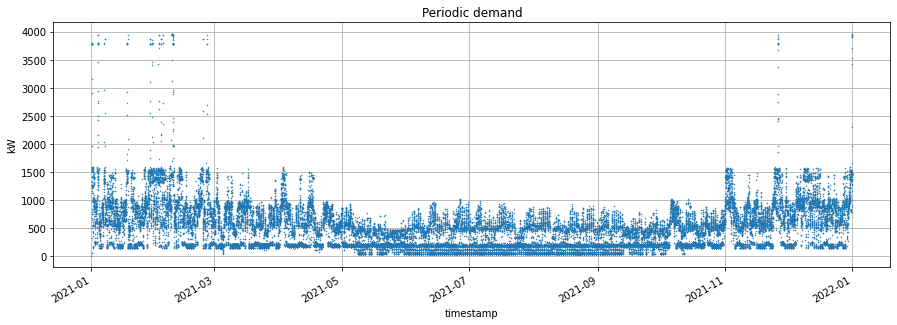

In [14]:
panel = pandas.read_csv('meter.csv',
                        header = 0,
                        names = ['timestamp','power'],
                        converters = {
                            'timestamp':to_timestamp,
                            'power':to_real},
                        index_col='timestamp')
panel['power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True,title='Periodic demand')

# Service Transformer
Typically more than one house is served by a single service transformer.  The following model provide the observed load for 4 homes on a single service transformer sampled at 1 minute intervals.

In [15]:
!cat transformer.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${STARTTIME:-"2021-01-01 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep ${SAMPLETIME:-60};
	object house:..${NHOMES:-4}
	{
		floor_area random.triangle(${FLOORAREA_MIN:-1000},${FLOORAREA_MAX:-3000});
	};
	object recorder
	{
		property "measured_real_energy_delta";
		file ${modelname/.glm/.csv};
		interval ${SAMPLETIME:-60};		
	};
}


In [16]:
!test transformer.glm -nt transformer.csv && gridlabd transformer.glm

Notice how much longer the simulation ran.  For larger models, we will run shorter simulation for illustration purposes, and address parallelization and performance improvements later.

<AxesSubplot:title={'center':'Service transformer load'}, xlabel='timestamp', ylabel='kW'>

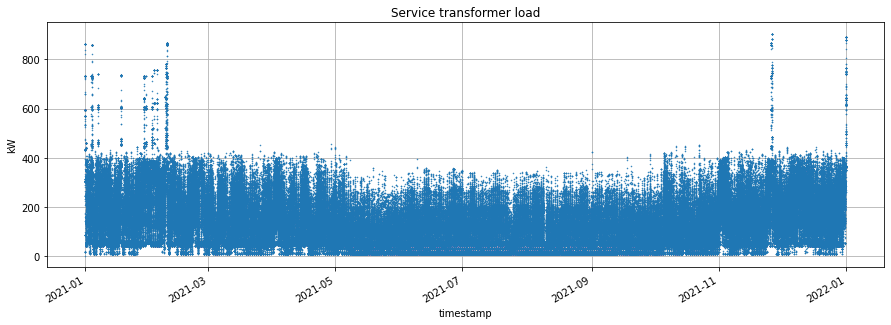

In [17]:
panel = pandas.read_csv('transformer.csv',
                        header = 0,
                        names = ['timestamp','power'],
                        converters = {
                            'timestamp':to_timestamp,
                            'power':to_real},
                        index_col='timestamp')
panel['power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True,title='Service transformer load')

# Feeder
At the feeder level, the total load could include several hundred homes, as illustrated by the following model. Note that the model does not include line losses between the feeder and the homes. Also, because the number of homes is so large, the annual simulation takes longer, so the time horizon is shortened to a month and the minimum simulation timestep is increased from the default of 1 second to match the sampling time. 

In [18]:
!cat feeder.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${STARTTIME:-"2021-01-01 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep ${SAMPLETIME:-60};
	object house:..${NHOMES:-50}
	{
		floor_area random.triangle(${FLOORAREA_MIN:-1000},${FLOORAREA_MAX:-3000});
	};
	object recorder
	{
		property "measured_real_energy_delta";
		file ${modelname/.glm/.csv};
		interval ${SAMPLETIME:-60};		
	};
}
#set minimum_timestep=${SAMPLETIME:-60}


In [19]:
!test feeder.glm -nt feeder.csv && gridlabd -D STOPTIME="2021-02-01 00:00:00 MST" feeder.glm

<AxesSubplot:title={'center':'Feeder load'}, xlabel='timestamp', ylabel='kW'>

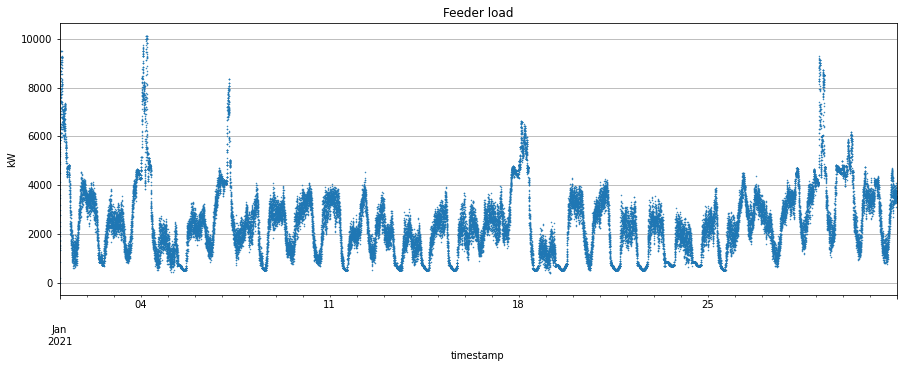

In [20]:
panel = pandas.read_csv('feeder.csv',
                        header = 0,
                        names = ['timestamp','power'],
                        converters = {
                            'timestamp':to_timestamp,
                            'power':to_real},
                        index_col='timestamp')
panel['power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True,title='Feeder load')

# Substation
The substation model has many more homes and takes longer to run. The data is sampled at 5 minute intervals, and the simulation uses the same minimum timestep.  (Having a timestep this large does have an adverse impact of the faster thermostatic models because it can result in some additional control overshoot.)  In addition, an initialization period has been added to avoid the initialization transient.

In [25]:
!cat substation.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${INITTIME:-"2020-12-26 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep ${SAMPLETIME:-300};
	object house:..${NHOMES:-250}
	{
		floor_area random.triangle(${FLOORAREA_MIN:-1000},${FLOORAREA_MAX:-3000});
	};
	object recorder
	{
		in_svc ${STARTTIME:-"2021-01-01 00:00:00 MST"};
		property "measured_real_energy_delta";
		file ${modelname/.glm/.csv};
		interval ${SAMPLETIME:-300};		
	};
}
#set minimum_timestep=${SAMPLETIME:-300}


In [22]:
!test substation.glm -nt substation.csv && gridlabd substation.glm

<AxesSubplot:title={'center':'Substation load'}, xlabel='timestamp', ylabel='kW'>

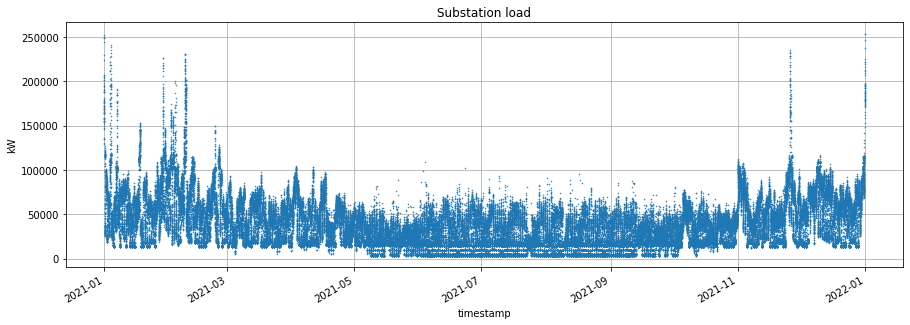

In [23]:
panel = pandas.read_csv('substation.csv',
                        header = 0,
                        names = ['timestamp','power'],
                        converters = {
                            'timestamp':to_timestamp,
                            'power':to_real},
                        index_col='timestamp')
panel['power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True,title='Substation load')

Here's a greyscale plot of the data with day of year plotted horizontally, and time of day plotted vertically.

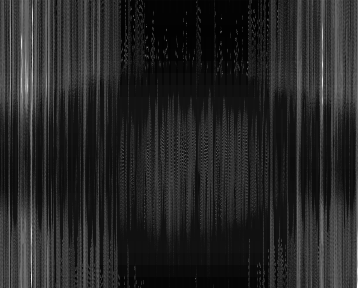

In [24]:
import PIL
nsamples=288
day0=7
ndays = int(len(panel.index)/nsamples-day0)
data = numpy.array(panel['power'][nsamples*day0:nsamples*(day0+ndays)])
data = numpy.reshape(data,(ndays,nsamples))/data.max()
PIL.Image.fromarray(numpy.uint8(data.transpose()*255),'L')